
⎯⎯⎯⎯ Sector 1 ⎯⎯⎯⎯
Sector: 2


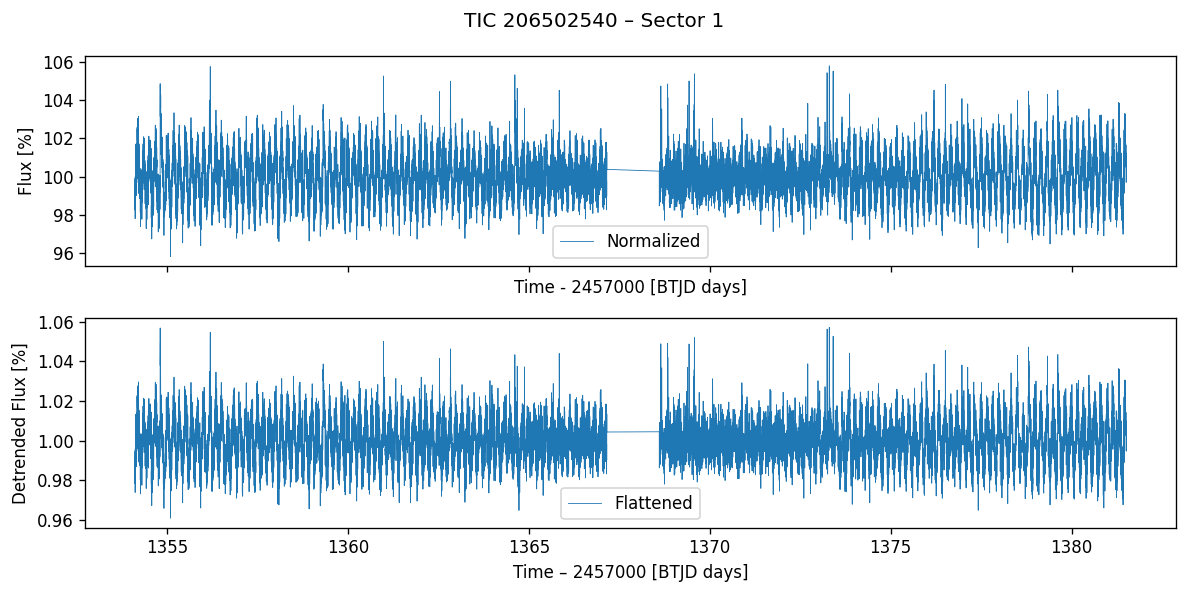

Best LS period: 0.16551 ± 0.00413 days


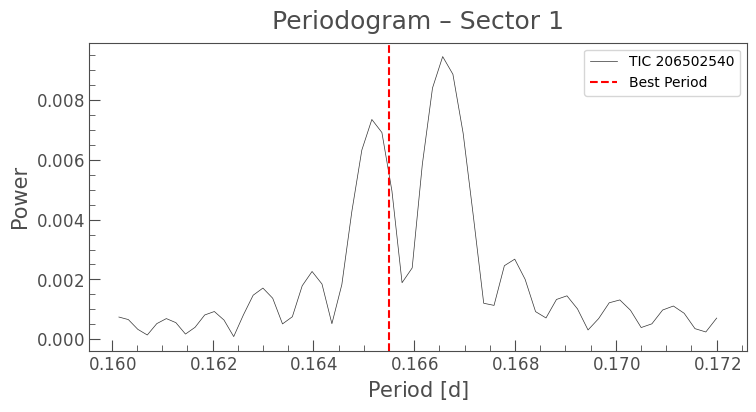


⎯⎯⎯⎯ Sector 2 ⎯⎯⎯⎯
Sector: 29


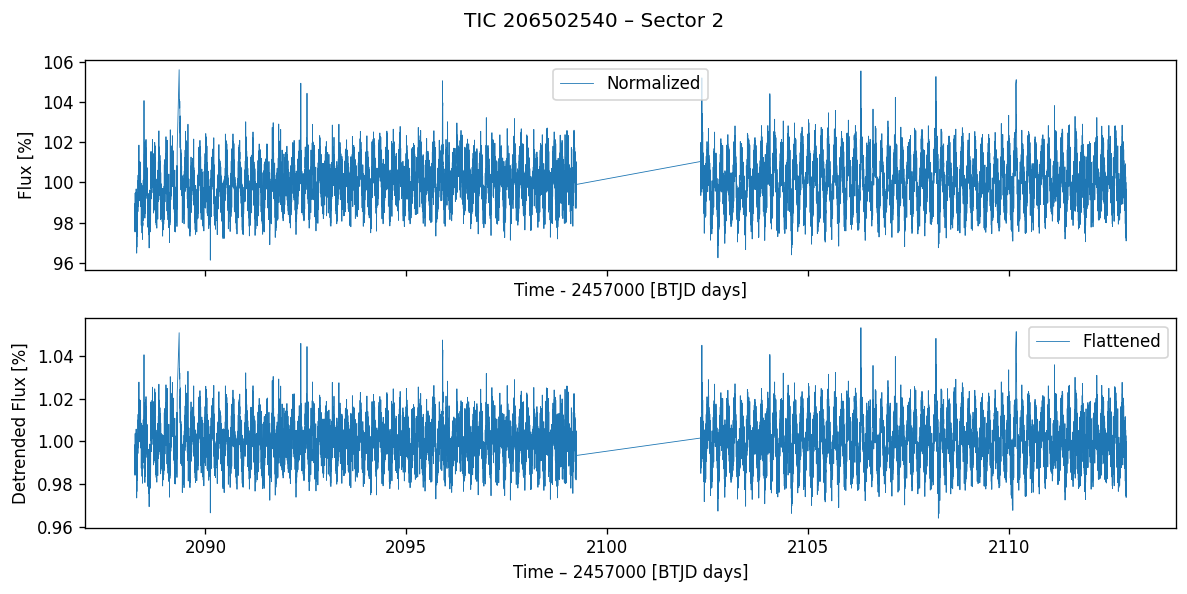

Best LS period: 0.16554 ± 0.00452 days


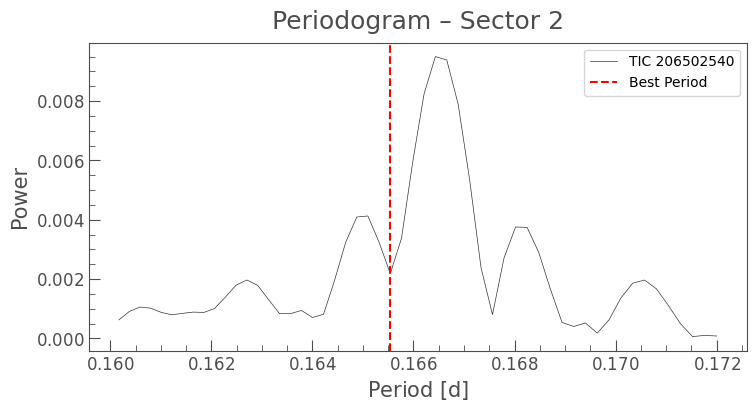


Summary Table of Periods:
   Sector  LS_period_d  LS_err_d
0       2     0.165507  0.004134
1      29     0.165539  0.004522

Saved table -> TIC206502540_periods_table.csv


In [10]:
import lightkurve as lk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from astropy.timeseries import LombScargle

# Target TIC ID
tic_id = "206502540"

# Search for all SPOC light curves from TESS
sr = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author="SPOC")

# Download light curves (PDCSAP_FLUX only)
lcs = sr.download_all(flux_column="pdcsap_flux", quality_bitmask="default")

results = []

# Loop over each sector
for i, lc_sector in enumerate(lcs):
    print(f"\n⎯⎯⎯⎯ Sector {i+1} ⎯⎯⎯⎯")
    print(f"Sector: {lc_sector.sector}")

    # Clean and normalize light curve
    lc_clean = lc_sector.normalize(unit="percent").remove_nans().remove_outliers(sigma=5)
    
    # Flatten for long-term trends
    lc_flat = lc_clean.flatten(window_length=401)

    # Plot raw and flattened lightcurve
    fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, dpi=120)
    lc_clean.plot(ax=ax[0], label="Normalized")
    ax[0].set_ylabel("Flux [%]")
    ax[0].legend()
    
    lc_flat.plot(ax=ax[1], label="Flattened")
    ax[1].set_ylabel("Detrended Flux [%]")
    ax[1].set_xlabel("Time – 2457000 [BTJD days]")
    ax[1].legend()
    plt.suptitle(f"TIC {tic_id} – Sector {i+1}")
    plt.tight_layout()
    plt.savefig("Lightcurve.png", dpi=300)
    
    plt.show()

    # Lomb-Scargle periodogram
    periodogram = lc_flat.to_periodogram(method="lombscargle",
                                         minimum_period=0.16,
                                         maximum_period=0.172)
    
    best_period = periodogram.period_at_max_power.value
    best_power = periodogram.max_power.value

   # --- Estimate error using bootstrap instead of FWHM ---
    rng = np.random.default_rng(42)
    nboot = 300  # number of bootstrap resamples
    boot_periods = []

    freq_grid = np.linspace(1/0.172, 1/0.16, 20000)  # same search range as periodogram
    for _ in range(nboot):
        flux_bs = rng.choice(lc_flat.flux.value, size=len(lc_flat.flux), replace=True)
        ls = LombScargle(lc_flat.time.value, flux_bs)
        power_bs = ls.power(freq_grid)
        f_best = freq_grid[np.argmax(power_bs)]
        boot_periods.append(1.0 / f_best)

    boot_periods = np.array(boot_periods)
    best_period = np.median(boot_periods)
    perr_lo, perr_hi = np.percentile(boot_periods, [16, 84])
    period_error = 0.5 * (perr_hi - perr_lo)  # 1σ error

    print(f"Best LS period: {best_period:.5f} ± {period_error:.5f} days")

    # Plot the periodogram
    periodogram.plot(title=f"Periodogram – Sector {i+1}")
    plt.axvline(best_period, color='r', linestyle='--', label="Best Period")
    plt.legend()
    plt.savefig("LS periodogram", dpi=300)
    plt.show()

# Store result
    results.append({
        "Sector": lc_sector.sector,
        "LS_period_d": best_period,
        "LS_err_d": period_error
    })

# Convert to DataFrame
df = pd.DataFrame(results, columns=["Sector", "LS_period_d", "LS_err_d"])
print("\nSummary Table of Periods:")
print(df)

# Save to CSV
csvfile = f"TIC{tic_id}_periods_table.csv"
df.to_csv(csvfile, index=False)
print(f"\nSaved table -> {csvfile}")


<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

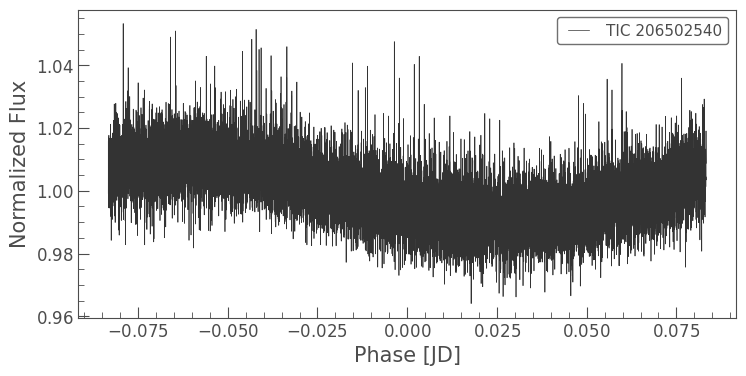

In [2]:
lc_fold_ls = lc_flat.fold(period= 0.166564)
lc_fold_ls.plot()


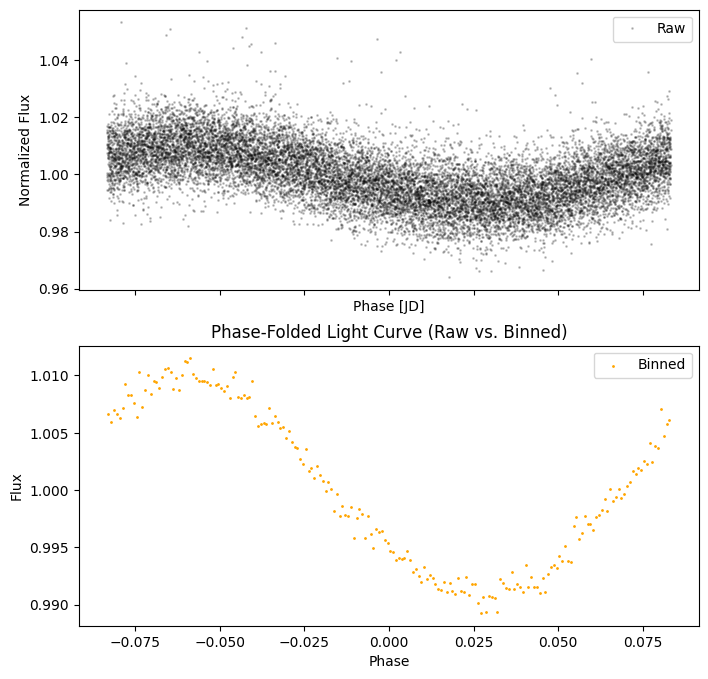

In [3]:
lc_fold_bin = lc_fold_ls.bin(bins=200)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Top panel: raw light curve
lc_fold_ls.plot(ax=ax1, alpha=0.2, label="Raw", color="black", marker='.', linestyle='none')
ax1.set_ylabel("Normalized Flux")
ax1.legend()

# Bottom panel: binned light curve
lc_fold_bin.scatter(ax=ax2, label="Binned", color="orange")
ax2.set_xlabel("Phase")
ax2.set_ylabel("Flux")
ax2.set_title("Phase-Folded Light Curve (Raw vs. Binned)")
ax2.legend()

plt.tight_layout
plt.savefig("phase_folded_lightcurve raw.png", dpi=300)
plt.savefig("phase_folded_lightcurve raw vs binned.png", dpi=300)
plt.show()

In [4]:
import lightkurve as lk

# Example: search by TIC ID
search_result = lk.search_lightcurve("TIC 206502540", mission="TESS")
print(search_result)


SearchResult containing 13 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 02 2018              SPOC     120   206502540      0.0
  1 TESS Sector 29 2020              SPOC     120   206502540      0.0
  2 TESS Sector 02 2018         TESS-SPOC    1800   206502540      0.0
  3 TESS Sector 29 2020         TESS-SPOC     600   206502540      0.0
  4 TESS Sector 69 2023         TESS-SPOC     200   206502540      0.0
  5 TESS Sector 02 2018               QLP    1800   206502540      0.0
  6 TESS Sector 29 2020               QLP     600   206502540      0.0
  7 TESS Sector 69 2023               QLP     200   206502540      0.0
  8 TESS Sector 02 2018             TASOC     120   206502540      0.0
  9 TESS Sector 02 2018 GSFC-ELEANOR-LITE    1800   206502540      0.0
 10 TESS Sector 02 2018           

In [5]:
import numpy as np

# Assume 'folded' is your folded light curve object
folded = lc_flat.fold(period= 0.1666)
amp = np.max(folded.flux.value) - np.min(folded.flux.value)
amp_percent = amp * 100
print(f"Peak-to-peak amplitude: {amp_percent:.2f}%")


Peak-to-peak amplitude: 8.92%
